In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os.path

from os import getcwd
import numpy as np 
import pandas as pd
import hdf5storage
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import savemat, loadmat
import math
from scipy.fftpack import fft, ifft
from scipy.stats import zscore, f_oneway
#import samplerate
import multiprocessing as mp
from scipy.signal import resample
import random
import pyreadr
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score
import statsmodels.api as sm
import scipy
import matplotlib.patches as mpatches
import statsmodels.stats.multitest as multitest
import mne
from mne.preprocessing import ICA
from mne.time_frequency import tfr_morlet

In [2]:
def get_info(field_num):
    field = []
    for item in range(trial_num):
        field.append(group_data['DATA'][0][item][field_num][0])
    return pd.DataFrame(field)

def load_time_series(subject, session, unit_id):
    #subj_mat = hdf5storage.loadmat(f"Z:\DBS\\{subject}\Preprocessed Data\SpikeSorting\\{subject}_ft_raw_spike.mat")
    subj_mat = hdf5storage.loadmat(f"/Volumes/Nexus/DBS/{subject}/Preprocessed Data/SpikeSorting/{subject}_ft_raw_spike.mat")
    time_data = subj_mat['IFR'][0]['time'][0][int(session-1)][0]
    neural_data = subj_mat['IFR'][0]['trial'][0][int(session-1)][int(unit_id-1)]
    
    time_data = time_data[~np.isnan(neural_data)]
    neural_data = neural_data[~np.isnan(neural_data)]
    
    return time_data, neural_data

def get_df(time_point, neural_data, time_data, after=3.5, before=1.5, fs=1000):
    dfs = []
    time_point = time_point[time_point<time_data.max()-2][time_point>time_data.min()+2]
    for item in time_point:
        for i2 in range(len(neural_data)):
            if time_data[i2] > item:
                dfs.append(neural_data[i2-int(before*fs):i2+int(after*fs)])
                break
    return np.array(dfs)

# function to convert to superscript
def get_super(x):
    normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
    super_s = "ᴬᴮᶜᴰᴱᶠᴳᴴᴵᴶᴷᴸᴹᴺᴼᴾQᴿˢᵀᵁⱽᵂˣʸᶻᵃᵇᶜᵈᵉᶠᵍʰᶦʲᵏˡᵐⁿᵒᵖ۹ʳˢᵗᵘᵛʷˣʸᶻ⁰¹²³⁴⁵⁶⁷⁸⁹⁺⁻⁼⁽⁾"
    res = x.maketrans(''.join(normal), ''.join(super_s))
    return x.translate(res)

In [3]:

#group_data = hdf5storage.loadmat(r"Z:\Commits\DBS_speech\Dev\U01SpikeAnalysis\data\group_data\group_data_narrow_09082021.mat")
#group_data = hdf5storage.loadmat(r"../../../../Macintosh HD/Users/yanming/Desktop/MGH BML/Sound-induced_STN_activity/manuscript/group_data_narrow_09082021.mat")
group_data = hdf5storage.loadmat(r"../../../../Macintosh HD/Users/yanming/Desktop/stn_auditory/group_data_narrow_09082021.mat")

trial_num = len(group_data['DATA'][0])

SubjectID = get_info(0)
SubjectID.columns = ['SubjectID']

session = get_info(1)
session.columns = ['session']

electrode = get_info(2)
electrode.columns = ['electrode']

unit_id = get_info(3)
unit_id.columns = ['unit_id']

unit = get_info(4)
unit.columns = ['unit']

RecType = get_info(5)
RecType.columns = ['RecType']

grade = get_info(6)
grade.columns = ['grade']

info = pd.concat([SubjectID, session, electrode, unit_id, unit, RecType, grade], axis=1)
info.head(2)
info.shape

SubjectID  session electrode  unit_id  unit RecType grade
0   DBS3001        1   micro_m        6     4      MU     B
1   DBS3001        2   micro_c        7     1      MU     C

(229, 7)

In [4]:
def get_subj_table(produced_freq, number_elec, info, timing_subj, neural_subj):
    SUBJ = info.iloc[number_elec, 0]
    SESS = info.iloc[number_elec, 1]
    subj_table = produced_freq[produced_freq.subject == SUBJ].reset_index(drop=1)
    subj_table = subj_table[subj_table.session_id == SESS].reset_index(drop=1)
    subj_table = subj_table[subj_table.starts > timing_subj.min()+3.5].reset_index(drop=1)
    subj_table = subj_table[subj_table.starts < timing_subj.max()-3.5].reset_index(drop=1)

        
    subj_table['avg_spike'] = np.nan
    for trial in range(subj_table.shape[0]):
        if subj_table.ends[trial] < timing_subj.max() - 3.5:
            if subj_table.starts[trial] > timing_subj.min() + 3.5:
                subj_table.avg_spike[trial] = get_avg_spike(subj_table.iloc[trial], 
                                                            neural_subj, timing_subj)
    subj_table = subj_table.dropna().reset_index(drop=1)
    
    subj_table['t_z'] = (subj_table['t'] - subj_table['t'].mean())/subj_table['t'].std(ddof=0)
    stim_vol_mean = subj_table['stim_volume'].mean()
    subj_table['stim_vol_z'] = (subj_table['stim_volume'] - 
                                   stim_vol_mean)/subj_table['stim_volume'].std(ddof=0)
    if subj_table['stim_volume'].unique().shape[0]==1:
        subj_table['stim_vol_z'] = 0
        

    subj_table['syl_id_z'] = (subj_table['syl_id'] - 
                              subj_table['syl_id'].mean())/subj_table['syl_id'].std(ddof=0)
    subj_table['spl_z'] = (subj_table['spl'] - 
                           subj_table['spl'].mean())/subj_table['spl'].std(ddof=0)
    stim_fac_mean = subj_table['stim_factor'].mean()
    subj_table['stim_z'] = (subj_table['stim_factor'] - 
                                   stim_fac_mean)/subj_table['stim_factor'].std(ddof=0)
    fund_freq_mean = subj_table['fundamental_freq'].mean()
    subj_table['pitch_z'] = (subj_table['fundamental_freq'] - 
                             fund_freq_mean)/subj_table['fundamental_freq'].std(ddof=0)
    subj_table['pitch_spl_z'] = subj_table['pitch_z']*subj_table['spl_z']

    return subj_table

In [5]:
def get_produced_freq():
    produced_freq = pd.read_csv('all_freq.csv', index_col='id')
    d = {'ah':0, 'oo':1, 'ee':2}
    produced_freq['stim_factor'] = produced_freq.stim.map(d)
    produced_freq['spl'] = 20*np.log10(produced_freq['rms_audio_p'])
    produced_freq = produced_freq.dropna().reset_index(drop=1)

    produced_freq['before_time'] = np.nan
    for item in range(1, produced_freq.shape[0]):
        if produced_freq.syl_id[item] == 2:
            if produced_freq.syl_id[item-1] == 1:
                produced_freq.before_time[item] = produced_freq.starts[item] - produced_freq.ends[item-1]
        elif produced_freq.syl_id[item] == 3:
            if produced_freq.syl_id[item-1] == 2:
                produced_freq.before_time[item] = produced_freq.starts[item] - produced_freq.ends[item-1]

    for item in range(1, produced_freq.shape[0]):
        if produced_freq.syl_id[item] == 1:
            if produced_freq.syl_id[item+1] == 2:
                if produced_freq.syl_id[item+2] == 3:
                    produced_freq.before_time[item] = (produced_freq.before_time[item+1] + 
                                                       produced_freq.before_time[item+2])/2

    produced_freq.before_time[0] = (produced_freq.before_time[1] + produced_freq.before_time[2])/2
    produced_freq = produced_freq.dropna().reset_index(drop=1)
    return produced_freq

produced_df = get_produced_freq()
produced_df.shape
produced_df.head(2)

(41210, 26)

starts          ends  duration    cons_onset  trial_id  session_id  \
0  36145.009713  36145.184457  0.174745  36145.009713         1           1   
1  36145.494905  36145.643055  0.148150  36145.494905         1           1   

   syl_id  channel  fundamental_freq   type  ...  subject         freq2  \
0       1  audio_p        142.196732  vowel  ...  DBS3001  20219.910530   
1       2  audio_p        140.861581  vowel  ...  DBS3001  19841.984898   

  discont contrun_id           t            t2            t3  stim_factor  \
0       1          1 -195.420094  38189.013071 -7.462901e+06            0   
1       0          1 -194.934901  37999.615755 -7.407451e+06            1   

         spl  before_time  
0 -18.178208     0.404081  
1 -21.894791     0.310448  

[2 rows x 26 columns]

In [6]:
def get_avg_spike(time_table, neural_data, time_data, fs=1000):
    time_point = time_table['starts']
    before = time_table['before_time']
    after = time_table['duration']
    dfs = []

    for item in range(len(neural_data)):
        if time_data[item] > time_point:
            dfs.append(neural_data[item-int(before*fs):item+int(after*fs)])
            break
    return np.mean(np.array(dfs))

In [7]:
def get_subj_df_cue(subject, sess, subj_table):
    #cue_df = pd.read_csv(f'Z:\DBS\\{subject}\Preprocessed Data\Sync\\annot\\{subject}_stimulus_syllable.txt', sep='	', index_col='id')
    cue_df = pd.read_csv(f'/Volumes/Nexus/DBS/{subject}/Preprocessed Data/Sync/annot/{subject}_stimulus_syllable.txt', sep='	', index_col='id')
    cue_df = cue_df[cue_df['session_id']==sess].reset_index(drop=1)
    subj_table_cue = pd.merge(subj_table, cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")
    return subj_table_cue

def find_rest_time(subject_df):
    resting_time = subject_df[subject_df['syl_id'] == 1]['starts_y'] - 1
    return resting_time

In [8]:

def find_full_3_trial(subj_table, timing_subj):
    good_trial = []
    subj_table = subj_table.dropna()
    subj_table = subj_table[subj_table['starts_y'] > timing_subj.min() + 3.5]
    subj_table = subj_table[subj_table['ends_x'] < timing_subj.max() - 3.5]
    for item in subj_table['trial_id'].unique():
        if subj_table[subj_table['trial_id'] == item].shape[0] == 3:
            good_trial.append(item)
    return subj_table[subj_table['trial_id'].isin(good_trial)]

In [9]:
def get_produced_phoneme(subject):
    #produced_phoneme = pd.read_csv(f'Z:\DBS\\{subject}\Preprocessed Data\Sync\\annot\\{subject}_produced_phoneme.txt', sep='	', index_col='id')
    produced_phoneme = pd.read_csv(f'/Volumes/Nexus/DBS/{subject}/Preprocessed Data/Sync/annot/{subject}_produced_phoneme.txt', sep='	', index_col='id')
    return produced_phoneme

def nansem(a, axis=1):
    return np.nanstd(a, axis=0)/np.sqrt(a.shape[axis])

In [10]:
def load_spikes(subject, session, unit_id):
    #subj_mat = hdf5storage.loadmat(f"Z:\DBS\\{subject}\Preprocessed Data\SpikeSorting\\{subject}_ft_raw_spike.mat")
    subj_mat = hdf5storage.loadmat(f"/Volumes/Nexus/DBS/{subject}/Preprocessed Data/SpikeSorting/{subject}_ft_raw_spike.mat")
    time_data = subj_mat['SpikeBin'][0]['time'][0][int(session-1)][0]
    neural_data = subj_mat['SpikeBin'][0]['trial'][0][int(session-1)][int(unit_id-1)]
    
    time_data = time_data[~np.isnan(neural_data)]
    neural_data = neural_data[~np.isnan(neural_data)]
    
    return time_data, neural_data

In [12]:
produced_start_1 = subj_df_cue[subj_df_cue['syl_id'] == 1]['starts_x']


NameError: name 'subj_df_cue' is not defined

Not setting metadata
115 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s finished


Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s finished


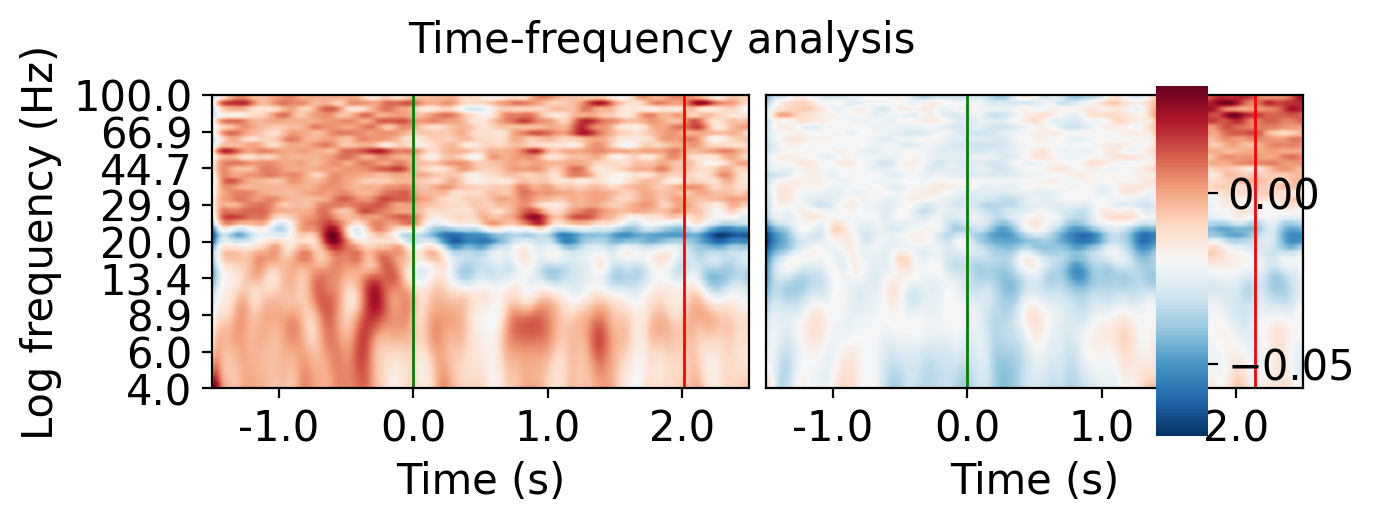

In [11]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(6.5, 2.5), dpi=200)
fig.patch.set_alpha(0)
axs[0].patch.set_alpha(0)
axs[1].patch.set_alpha(0)

number_elec = 56

SUBJECT = info.iloc[number_elec, 0]
session = info.iloc[number_elec, 1]
contact = info.iloc[number_elec, 3]

timing, neural_df = load_time_series(SUBJECT, session, contact)
subj_df = get_subj_table(produced_df, number_elec, info, timing, neural_df)
subj_df_cue = get_subj_df_cue(SUBJECT, session, subj_df)
subj_df_cue = find_full_3_trial(subj_df_cue, timing)

timing_spike, spike_df = load_spikes(SUBJECT, session, contact)
relative_time = subj_df_cue[subj_df_cue['syl_id'] == 1]['starts_y']
produced_start_1 = subj_df_cue[subj_df_cue['syl_id'] == 1]['starts_x']

spikes = get_df(relative_time, spike_df, timing_spike, after=3.5, before=1.5)
tf_mat = np.expand_dims(spikes, axis=1)
tf_mat = mne.EpochsArray(tf_mat, mne.create_info([f'{number_elec}'], 1000))
freqs = np.logspace(*np.log10([4, 100]), num=49)
n_cycles = freqs / 2.
power, itc = tfr_morlet(tf_mat, freqs=freqs, n_cycles=n_cycles, picks='all')
times = np.linspace(0, 5, 5000)
extent = (times[0], times[-1], freqs[0], freqs[-1])
power_rescale = mne.baseline.rescale(power.data[0], tf_mat.times, (0.5, 1))


im1 = axs[0].imshow(power_rescale, extent=extent, aspect="auto", 
        origin="lower", cmap='RdBu_r')

axs[0].set_xticks(np.linspace(0.5, 4.5, 5))
axs[0].set_xticklabels(np.linspace(-1, 3, 5), fontsize=15)
axs[0].set_yticks(np.linspace(4, 100, 9))
axs[0].set_yticklabels(np.round(freqs[::6], decimals=1), fontsize=15)
axs[0].set_xlabel('Time (s)', fontsize=15)
axs[0].set_ylabel('Log frequency (Hz)', fontsize=15)
axs[0].axvline(1.5, color='g', linewidth=1)
axs[0].axvline(produced_start_1.mean() - relative_time.mean()+1.5, 
                                      color='r', linewidth=1)
axs[0].set_xlim(0, 4)


number_elec = 48

SUBJECT = info.iloc[number_elec, 0]
session = info.iloc[number_elec, 1]
contact = info.iloc[number_elec, 3]

timing, neural_df = load_time_series(SUBJECT, session, contact)
subj_df = get_subj_table(produced_df, number_elec, info, timing, neural_df)
subj_df_cue = get_subj_df_cue(SUBJECT, session, subj_df)
subj_df_cue = find_full_3_trial(subj_df_cue, timing)

timing_spike, spike_df = load_spikes(SUBJECT, session, contact)
relative_time = subj_df_cue[subj_df_cue['syl_id'] == 1]['starts_y']
produced_start_1 = subj_df_cue[subj_df_cue['syl_id'] == 1]['starts_x']

spikes = get_df(relative_time, spike_df, timing_spike, after=3.5, before=1.5)
tf_mat = np.expand_dims(spikes, axis=1)
tf_mat = mne.EpochsArray(tf_mat, mne.create_info([f'{number_elec}'], 1000))
freqs = np.logspace(*np.log10([4, 100]), num=49)
n_cycles = freqs / 2.
power, itc = tfr_morlet(tf_mat, freqs=freqs, n_cycles=n_cycles, picks='all')
times = np.linspace(0, 5, 5000)
extent = (times[0], times[-1], freqs[0], freqs[-1])
power_rescale = mne.baseline.rescale(power.data[0], tf_mat.times, (0.5, 1))


im2 = axs[1].imshow(power_rescale, extent=extent, aspect="auto", 
        origin="lower", cmap='RdBu_r')

axs[1].set_xticks(np.linspace(0.5, 4.5, 5))
axs[1].set_xticklabels(np.linspace(-1, 3, 5), fontsize=15)
#axs[1].set_yticks(np.linspace(4, 100, 9))
axs[1].set_yticks([])
#axs[1].set_yticklabels(np.round(freqs[::6], decimals=1), fontsize=15)
axs[1].set_xlabel('Time (s)', fontsize=15)
#axs[1].set_ylabel('Log frequency (Hz)', fontsize=15)
#axs[1].set_title("Time-frequency analysis", fontsize=15)
axs[1].axvline(1.5, color='g', linewidth=1)
axs[1].axvline(produced_start_1.mean() - relative_time.mean()+1.5, 
                                      color='r', linewidth=1)
axs[1].set_xlim(0, 4)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
cb = fig.colorbar(im1, cax=cbar_ax)
cbar_ax.tick_params(labelsize=15)
cb.outline.set_linewidth(0)

plt.suptitle("Time-frequency analysis", fontsize=15)

#plt.show();

plt.savefig("../plots/fig4a2.svg", format = 'svg', dpi=200);


In [11]:
number_elec = 56

SUBJECT = info.iloc[number_elec, 0]
session = info.iloc[number_elec, 1]
contact = info.iloc[number_elec, 3]

timing, neural_df = load_time_series(SUBJECT, session, contact)
subj_df = get_subj_table(produced_df, number_elec, info, timing, neural_df)
subj_df_cue = get_subj_df_cue(SUBJECT, session, subj_df)
subj_df_cue = find_full_3_trial(subj_df_cue, timing)

timing_spike, spike_df = load_spikes(SUBJECT, session, contact)
relative_time = subj_df_cue[subj_df_cue['syl_id'] == 1]['starts_y']

spikes = get_df(relative_time, spike_df, timing_spike, after=3.5, before=1.5)
tf_mat = np.expand_dims(spikes, axis=1)
tf_mat = mne.EpochsArray(tf_mat, mne.create_info([f'{number_elec}'], 1000))
freqs = np.logspace(*np.log10([4, 100]), num=49)
n_cycles = freqs / 2.
power, itc = tfr_morlet(tf_mat, freqs=freqs, n_cycles=n_cycles, picks='all')
times = np.linspace(0, 5, 5000)
extent = (times[0], times[-1], freqs[0], freqs[-1])
power_rescale = mne.baseline.rescale(power.data[0], tf_mat.times, (0.5, 1))


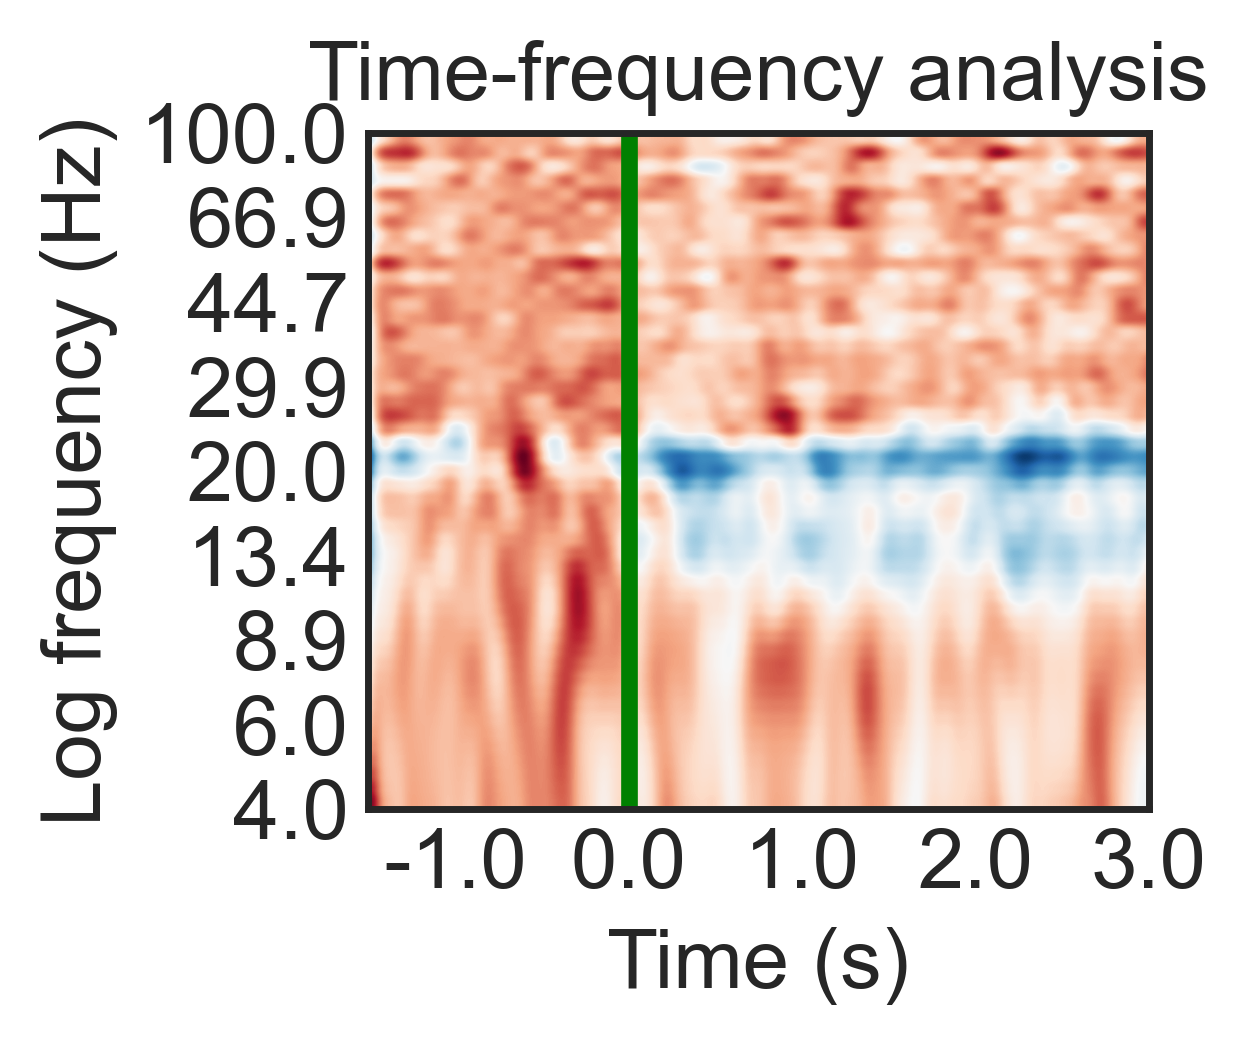

In [22]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(3, 2.5), dpi=200)
fig.patch.set_alpha(0)
axs.patch.set_alpha(0)
axs.imshow(power_rescale, extent=extent, aspect="auto", 
        origin="lower", cmap='RdBu_r')

axs.set_xticks(np.linspace(0.5, 4.5, 5))
axs.set_xticklabels(np.linspace(-1, 3, 5), fontsize=15)
axs.set_yticks(np.linspace(4, 100, 9))
axs.set_yticklabels(np.round(freqs[::6], decimals=1), fontsize=15)
axs.set_xlabel('Time (s)', fontsize=15)
axs.set_ylabel('Log frequency (Hz)', fontsize=15)
axs.set_title("Time-frequency analysis", fontsize=15)
axs.axvline(1.5, color='g', linewidth=3)
axs.set_xlim(0, 4.5)
#plt.plot();
plt.savefig("../plots/fig4a1.svg", format = 'svg', dpi=200);


In [23]:
number_elec = 48

SUBJECT = info.iloc[number_elec, 0]
session = info.iloc[number_elec, 1]
contact = info.iloc[number_elec, 3]

timing, neural_df = load_time_series(SUBJECT, session, contact)
subj_df = get_subj_table(produced_df, number_elec, info, timing, neural_df)
subj_df_cue = get_subj_df_cue(SUBJECT, session, subj_df)
subj_df_cue = find_full_3_trial(subj_df_cue, timing)

timing_spike, spike_df = load_spikes(SUBJECT, session, contact)
relative_time = subj_df_cue[subj_df_cue['syl_id'] == 1]['starts_y']

spikes = get_df(relative_time, spike_df, timing_spike, after=3.5, before=1.5)
tf_mat = np.expand_dims(spikes, axis=1)
tf_mat = mne.EpochsArray(tf_mat, mne.create_info([f'{number_elec}'], 1000))
freqs = np.logspace(*np.log10([4, 100]), num=49)
n_cycles = freqs / 2.
power, itc = tfr_morlet(tf_mat, freqs=freqs, n_cycles=n_cycles, picks='all')
times = np.linspace(0, 5, 5000)
extent = (times[0], times[-1], freqs[0], freqs[-1])
power_rescale = mne.baseline.rescale(power.data[0], tf_mat.times, (0.5, 1))


Not setting metadata
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Applying baseline correction (mode: mean)


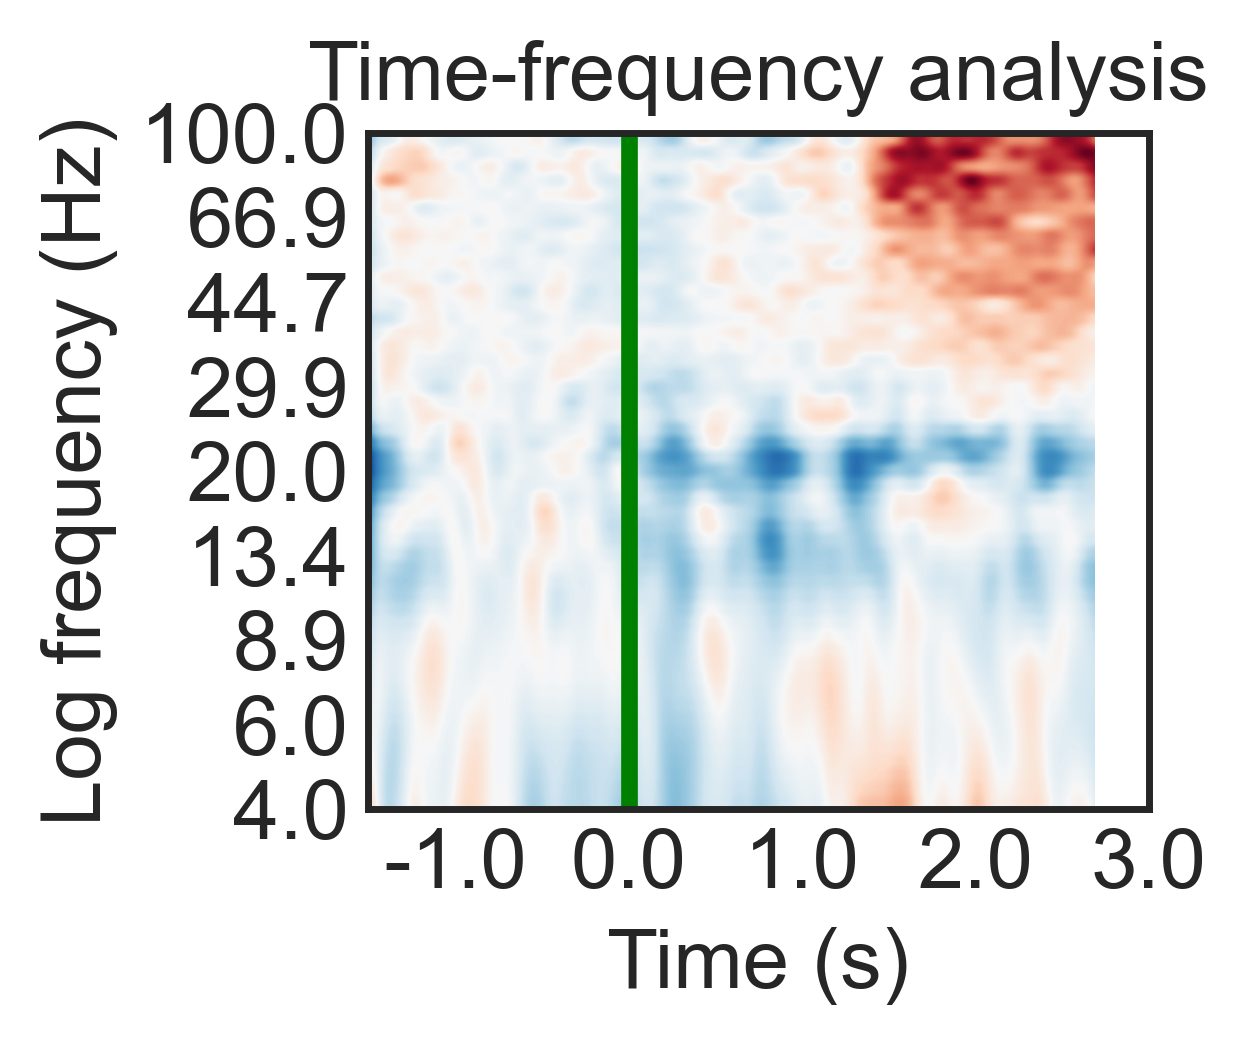

In [24]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(3, 2.5), dpi=200)
fig.patch.set_alpha(0)
axs.patch.set_alpha(0)
axs.imshow(power_rescale, extent=extent, aspect="auto", 
        origin="lower", cmap='RdBu_r')

axs.set_xticks(np.linspace(0.5, 4.5, 5))
axs.set_xticklabels(np.linspace(-1, 3, 5), fontsize=15)
axs.set_yticks(np.linspace(4, 100, 9))
axs.set_yticklabels(np.round(freqs[::6], decimals=1), fontsize=15)
axs.set_xlabel('Time (s)', fontsize=15)
axs.set_ylabel('Log frequency (Hz)', fontsize=15)
axs.set_title("Time-frequency analysis", fontsize=15)
axs.axvline(1.5, color='g', linewidth=3)
axs.set_xlim(0, 4.5)
#plt.plot();
plt.savefig("../plots/fig4a2.svg", format = 'svg', dpi=200);


In [18]:
spikes.shape

(115, 5000)

In [16]:
number_elec = 56

SUBJECT = info.iloc[number_elec, 0]
session = info.iloc[number_elec, 1]
contact = info.iloc[number_elec, 3]

timing, neural_df = load_time_series(SUBJECT, session, contact)
subj_df = get_subj_table(produced_df, number_elec, info, timing, neural_df)
subj_df_cue = get_subj_df_cue(SUBJECT, session, subj_df)
subj_df_cue = find_full_3_trial(subj_df_cue, timing)

timing_spike, spike_df = load_spikes(SUBJECT, session, contact)
relative_time = subj_df_cue[subj_df_cue['syl_id'] == 1]['starts_y']

spikes = get_df(relative_time, spike_df, timing_spike, after=3.5, before=1.5)
tf_mat = np.expand_dims(spikes, axis=1)
tf_mat = mne.EpochsArray(tf_mat, mne.create_info([f'{number_elec}'], 1000))
freqs = np.logspace(*np.log10([4, 100]), num=49)
n_cycles = freqs / 2.
power, itc = tfr_morlet(tf_mat, freqs=freqs, n_cycles=n_cycles, picks='all')
times = np.linspace(0, 5, 5000)
extent = (times[0], times[-1], freqs[0], freqs[-1])
power_rescale = mne.baseline.rescale(power.data[0], tf_mat.times, (0.5, 1))


Not setting metadata
115 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s finished


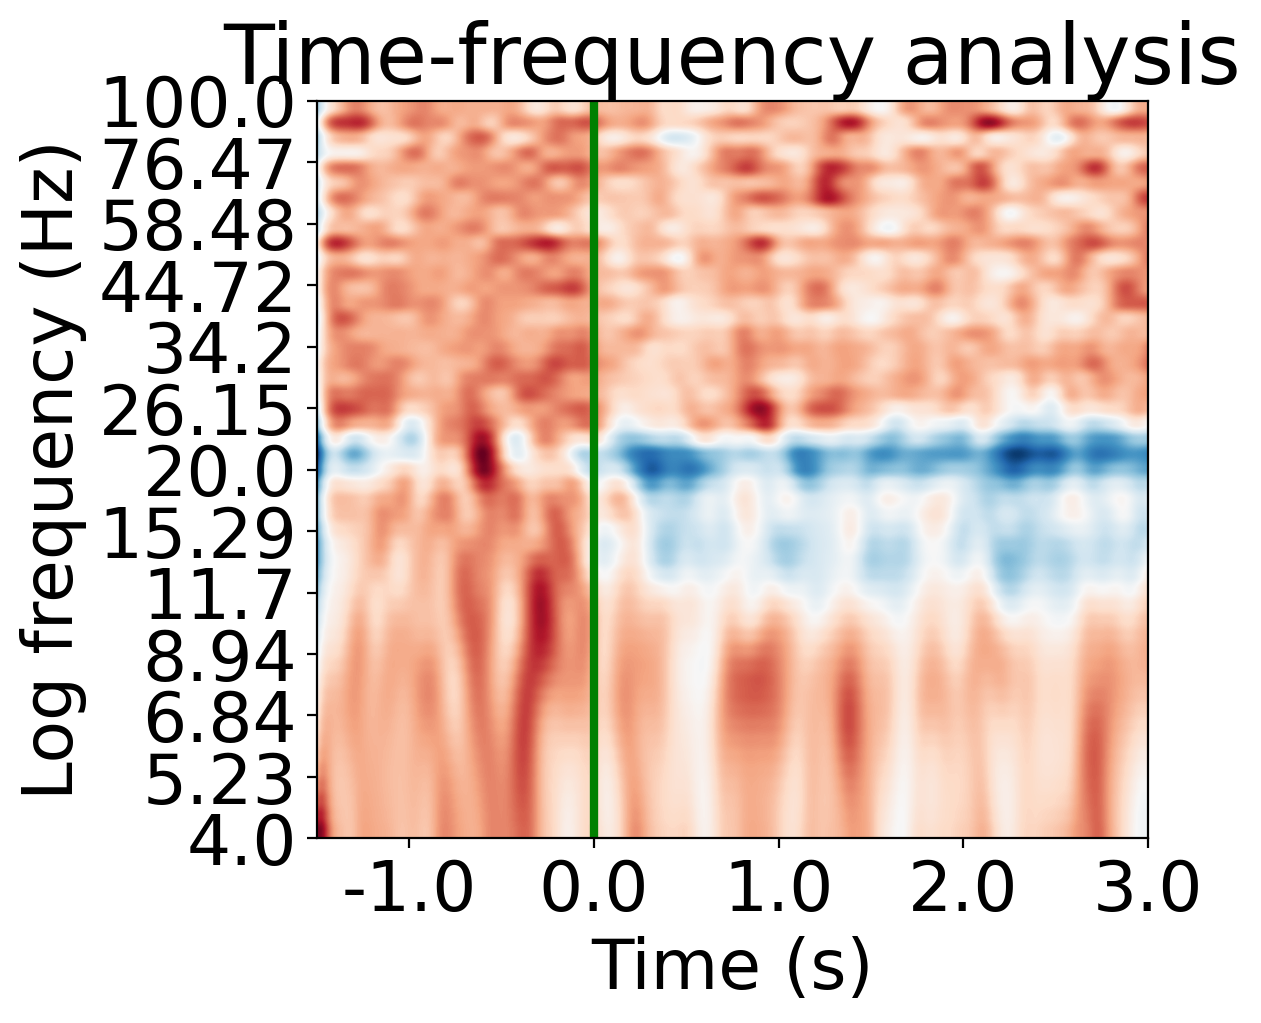

In [17]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(6, 5), dpi=200)
axs.patch.set_alpha(0)
axs.imshow(power_rescale, extent=extent, aspect="auto", 
        origin="lower", cmap='RdBu_r')

axs.set_xticks(np.linspace(0.5, 4.5, 5))
axs.set_xticklabels(np.linspace(-1, 3, 5), fontsize=25)
axs.set_yticks(np.linspace(4, 100, 13))
axs.set_yticklabels(np.round(freqs[::4], decimals=2), fontsize=25)
axs.set_xlabel('Time (s)', fontsize=25)
axs.set_ylabel('Log frequency (Hz)', fontsize=25)
axs.set_title("Time-frequency analysis", fontsize=30)
axs.axvline(1.5, color='g', linewidth=3)
axs.set_xlim(0, 4.5)
plt.plot();

In [56]:
number_elec = 56

SUBJECT = info.iloc[number_elec, 0]
session = info.iloc[number_elec, 1]
contact = info.iloc[number_elec, 3]

timing, neural_df = load_time_series(SUBJECT, session, contact)
subj_df = get_subj_table(produced_df, number_elec, info, timing, neural_df)
subj_df_cue = get_subj_df_cue(SUBJECT, session, subj_df)
subj_df_cue = find_full_3_trial(subj_df_cue, timing)

timing_spike, spike_df = load_spikes(SUBJECT, session, contact)
relative_time = subj_df_cue[subj_df_cue['syl_id'] == 1]['starts_y']

spikes = get_df(relative_time, spike_df, timing_spike, after=3.5, before=1.5)
tf_mat = np.expand_dims(spikes, axis=1)
tf_mat = mne.EpochsArray(tf_mat, mne.create_info([f'{number_elec}'], 1000))
freqs = np.logspace(*np.log10([10, 150]), num=49)
n_cycles = freqs / 2.
power, itc = tfr_morlet(tf_mat, freqs=freqs, n_cycles=n_cycles, picks='all')
times = np.linspace(0, 5, 5000)
extent = (times[0], times[-1], freqs[0], freqs[-1])
power_rescale = mne.baseline.rescale(power.data[0], tf_mat.times, (0.5, 1))


Not setting metadata
115 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s finished


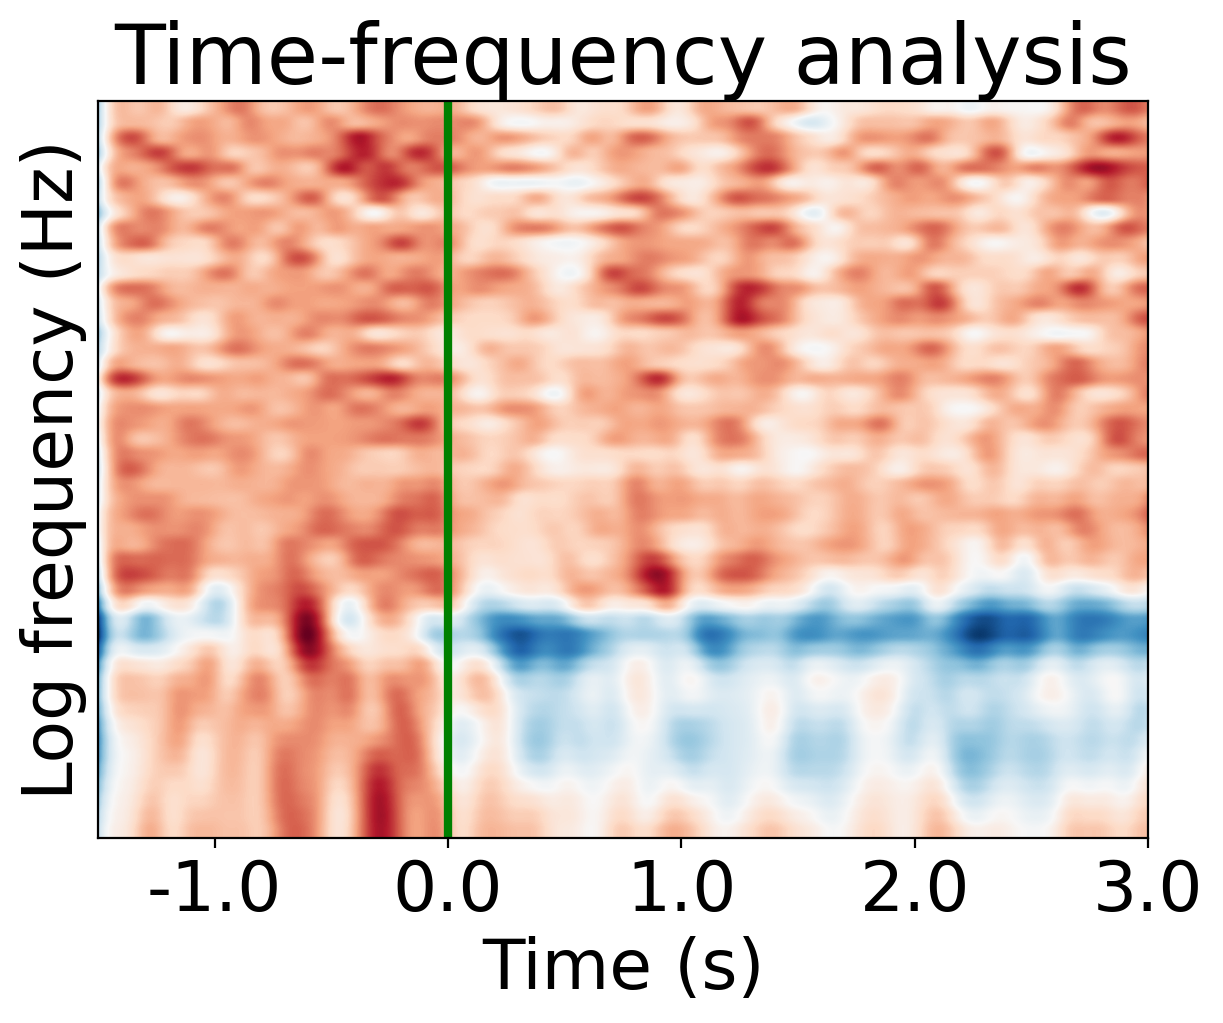

In [57]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(6, 5), dpi=200)
axs.patch.set_alpha(0)
axs.imshow(power_rescale, extent=extent, aspect="auto", 
        origin="lower", cmap='RdBu_r')

axs.set_xticks(np.linspace(0.5, 4.5, 5))
axs.set_xticklabels(np.linspace(-1, 3, 5), fontsize=25)
axs.set_yticks(np.log10([10, 150]))
axs.set_yticklabels(np.round(np.log10([10, 150]), decimals=2), fontsize=25)
axs.set_xlabel('Time (s)', fontsize=25)
axs.set_ylabel('Log frequency (Hz)', fontsize=25)
axs.set_title("Time-frequency analysis", fontsize=30)
axs.axvline(1.5, color='g', linewidth=3)
axs.set_xlim(0, 4.5)
plt.plot();

In [16]:
xvals = np.linspace(-1.5, 3.5, 5000)


In [13]:
number_elec = 56

SUBJECT = info.iloc[number_elec, 0]
session = info.iloc[number_elec, 1]
contact = info.iloc[number_elec, 3]

timing, neural_df = load_time_series(SUBJECT, session, contact)
subj_df = get_subj_table(produced_df, number_elec, info, timing, neural_df)
subj_df_cue = get_subj_df_cue(SUBJECT, session, subj_df)
subj_df_cue = find_full_3_trial(subj_df_cue, timing)

timing_spike, spike_df = load_spikes(SUBJECT, session, contact)
relative_time = subj_df_cue[subj_df_cue['syl_id'] == 1]['starts_y']

spikes = get_df(relative_time, spike_df, timing_spike, after=3.5, before=1.5)
tf_mat = np.expand_dims(spikes, axis=1)
tf_mat = mne.EpochsArray(tf_mat, mne.create_info([f'{number_elec}'], 1000))
freqs = np.logspace(*np.log10([10, 150]), num=49)
n_cycles = freqs / 2.
power, itc = tfr_morlet(tf_mat, freqs=freqs, n_cycles=n_cycles, picks='all')
times = np.linspace(0, 5, 5000)
extent = (times[0], times[-1], freqs[0], freqs[-1])
power_rescale = mne.baseline.rescale(power.data[0], tf_mat.times, (0.5, 1))


Not setting metadata
115 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished


In [14]:
power_rescale_ = np.zeros((spikes.shape[0], 49, spikes.shape[1]))

timing_spike, spike_df = load_spikes(SUBJECT, session, contact)
spikes = get_df(relative_time, spike_df, timing_spike, after=3.5, before=1.5)
tf_mat = np.expand_dims(spikes, axis=1)
for item in range(spikes.shape[0]):

    tf_mat_use = np.expand_dims(tf_mat[item], axis=1)

    tf_mat_use = mne.EpochsArray(tf_mat_use, mne.create_info([f'{number_elec}'], 1000))
    freqs = np.logspace(*np.log10([10, 150]), num=49)
    n_cycles = freqs / 2.
    power, itc = tfr_morlet(tf_mat_use, freqs=freqs, n_cycles=n_cycles, picks='all')
    times = np.linspace(0, 5, 5000)
    extent = (times[0], times[-1], freqs[0], freqs[-1])
    power_rescaled = mne.baseline.rescale(power.data[0], tf_mat_use.times, (0.5, 1))
    power_rescale_[item] = power_rescaled
    

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [17]:
power_rescale_sig = np.zeros((49, 5000))

for item in range(power_rescale_.shape[1]):
    print(item)
    power_rescale_use = power_rescale_[:, item]
    power_rescale_rest = power_rescale_use[:, :1000]
    rest_mean = power_rescale_rest.mean()
    rest_std = np.std(power_rescale_rest)
    rest_sem = rest_std/np.sqrt(power_rescale_rest.shape[0])
    FR_compare = np.random.randn(100, 5000)*rest_std+rest_mean
    
    significance = pd.DataFrame({"xvals":xvals, 
                                     "pval":f_oneway(power_rescale_use, FR_compare).pvalue})
    for i2 in range(len(xvals)):
        if multitest.fdrcorrection(significance.pval)[0][i2] == True:
            #if power_rescale_use[item, i2] < rest_mean:
            power_rescale_sig[item, i2] = 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


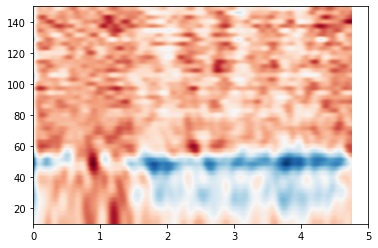

In [18]:
im1 = plt.imshow(power_rescale, extent=extent, aspect="auto", 
        origin="lower", cmap='RdBu_r')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
cb = fig.colorbar(im1, cax=cbar_ax)
cbar_ax.tick_params(labelsize=10)
cb.outline.set_linewidth(0)


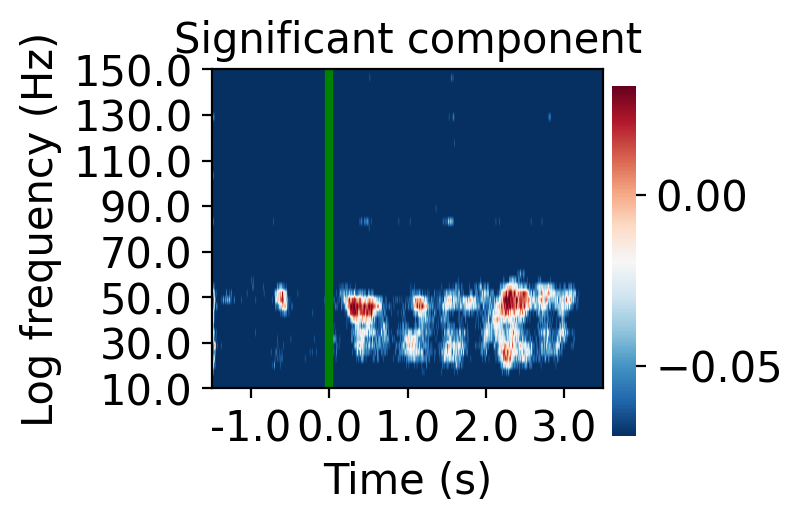

In [19]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(3, 2.5), dpi=200)
axs.patch.set_alpha(0)

axs.imshow(power_rescale_sig, extent=extent, aspect="auto", 
        origin="lower", cmap='RdBu_r')
axs.set_xticks(np.linspace(0.5, 4.5, 5))
axs.set_xticklabels(np.linspace(-1, 3, 5), fontsize=15)
axs.set_yticks(np.linspace(10, 150, 8))
axs.set_yticklabels(np.round(np.linspace(10, 150, 8), decimals=1), fontsize=15)
axs.set_xlabel('Time (s)', fontsize=15)
axs.set_ylabel('Log frequency (Hz)', fontsize=15)
axs.set_title("Significant component", fontsize=15)
axs.axvline(1.5, color='g', linewidth=3)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1, 0.15, 0.04, 0.7])
cb = fig.colorbar(im1, cax=cbar_ax)
cbar_ax.tick_params(labelsize=15)
cb.outline.set_linewidth(0)
#plt.plot();
plt.savefig("../plots/fig4b.svg", format = 'svg', dpi=200);
#plt.close(fig);

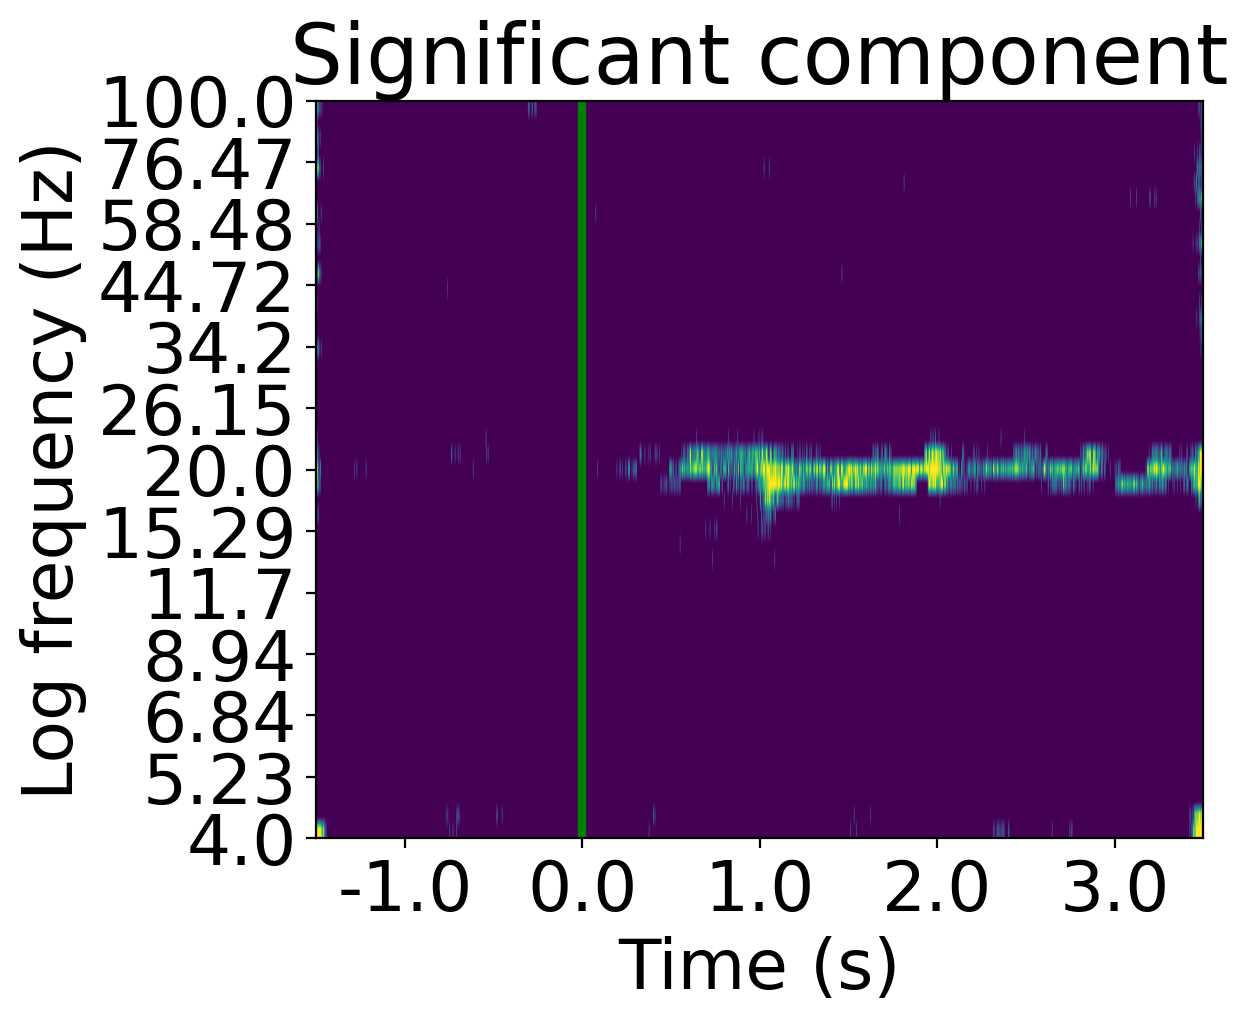

In [39]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(6, 5), dpi=200)
axs.patch.set_alpha(0)

axs.imshow(power_rescale_sig, extent=extent, aspect="auto", 
        origin="lower")
axs.set_xticks(np.linspace(0.5, 4.5, 5))
axs.set_xticklabels(np.linspace(-1, 3, 5), fontsize=25)
axs.set_yticks(np.linspace(4, 100, 13))
axs.set_yticklabels(np.round(freqs[::4], decimals=2), fontsize=25)
axs.set_xlabel('Time (s)', fontsize=25)
axs.set_ylabel('Log frequency (Hz)', fontsize=25)
axs.set_title("Significant component", fontsize=30)
axs.axvline(1.5, color='g', linewidth=3)

plt.plot();
#plt.savefig(f'sprectrum\\{number_elec} {SUBJECT} Unit {contact} at Session {session}.jpeg', dpi=200);
#plt.close(fig);

In [21]:
import matplotlib.patches as patches


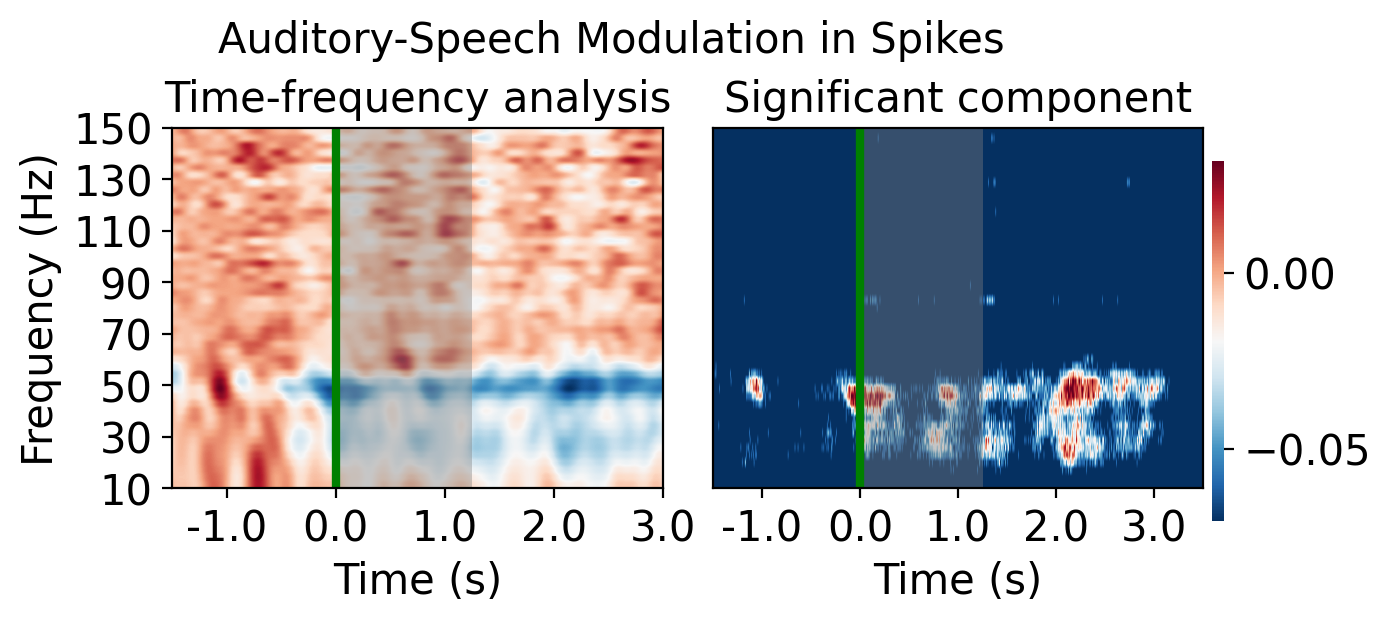

In [30]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(6, 3), dpi=200)
fig.patch.set_alpha(0)
axs[0].patch.set_alpha(0)
axs[0].imshow(power_rescale, extent=extent, aspect="auto", 
        origin="lower", cmap='RdBu_r')

axs[0].set_xticks(np.linspace(0.5, 4.5, 5))
axs[0].set_xticklabels(np.linspace(-1, 3, 5), fontsize=15)
axs[0].set_yticks(np.linspace(10, 150, 8))
#axs[0].set_yticklabels(np.round(np.linspace(10, 150, 8), decimals=0), fontsize=15)
axs[0].set_yticklabels(np.linspace(10, 150, 8, dtype=int), fontsize=15)
axs[0].set_xlabel('Time (s)', fontsize=15)
axs[0].set_ylabel('Frequency (Hz)', fontsize=15)
axs[0].set_title("Time-frequency analysis", fontsize=15)
axs[0].axvline(1.5, color='g', linewidth=3)
axs[0].set_xlim(0, 4.5)

rect1 = patches.Rectangle((1.5, 0), 1.25, 150, edgecolor='none', facecolor='grey', alpha=0.4)
axs[0].add_patch(rect1)


axs[1].patch.set_alpha(0)

axs[1].imshow(power_rescale_sig, extent=extent, aspect="auto", 
        origin="lower", cmap='RdBu_r')
axs[1].set_xticks(np.linspace(0.5, 4.5, 5))
axs[1].set_xticklabels(np.linspace(-1, 3, 5), fontsize=15)
axs[1].set_yticks([])
axs[1].set_yticklabels([])
axs[1].set_xlabel('Time (s)', fontsize=15)
#axs[1].set_ylabel('Log frequency (Hz)', fontsize=15)
axs[1].set_title("Significant component", fontsize=15)
axs[1].axvline(1.5, color='g', linewidth=3)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1, 0.15, 0.01, 0.6])
cb = fig.colorbar(im1, cax=cbar_ax)
cbar_ax.tick_params(labelsize=15)
cb.outline.set_linewidth(0)
#cb.set_ticks((-25000, 0, 25000))
#cb.set_ticklabels([-2.5, 0, 2.5])

rect2 = patches.Rectangle((1.5, 0), 1.25, 150, edgecolor='none', facecolor='grey', alpha=0.4)
axs[1].add_patch(rect2)

plt.suptitle('Auditory-Speech Modulation in Spikes', fontsize=15)
plt.plot();



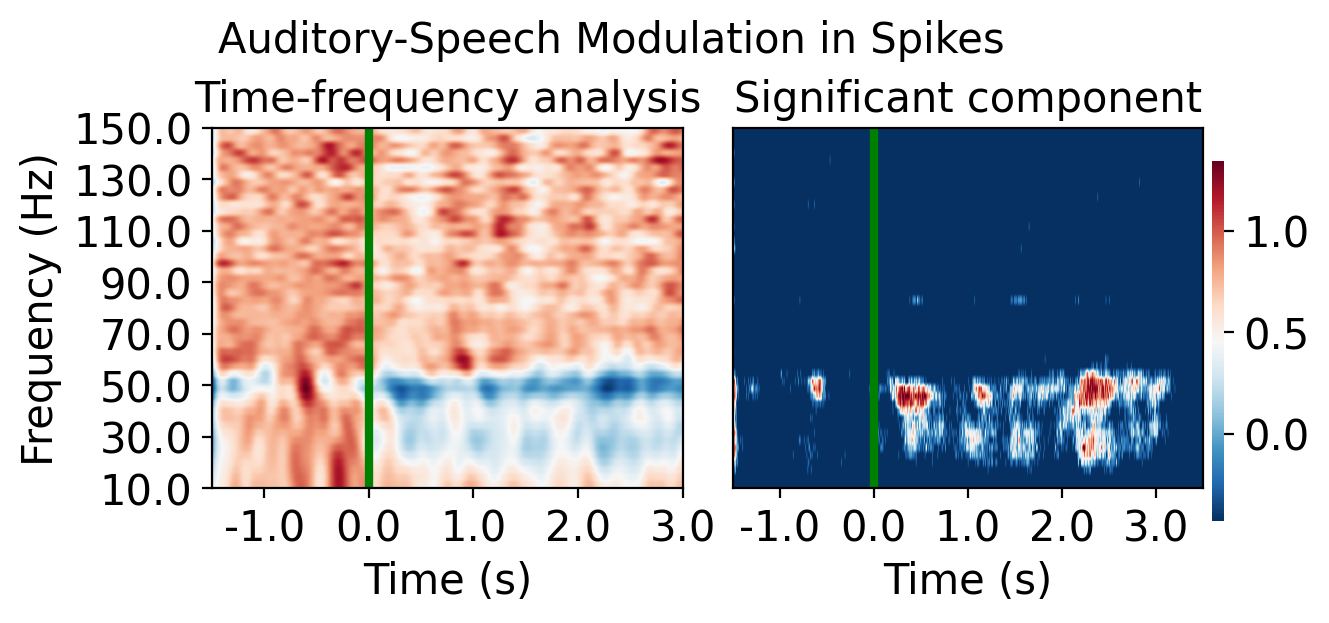

In [64]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(6, 3), dpi=200)
fig.patch.set_alpha(0)
axs[0].patch.set_alpha(0)
axs[0].imshow(power_rescale, extent=extent, aspect="auto", 
        origin="lower", cmap='RdBu_r')

axs[0].set_xticks(np.linspace(0.5, 4.5, 5))
axs[0].set_xticklabels(np.linspace(-1, 3, 5), fontsize=15)
axs[0].set_yticks(np.linspace(10, 150, 8))
axs[0].set_yticklabels(np.round(np.linspace(10, 150, 8), decimals=1), fontsize=15)
axs[0].set_xlabel('Time (s)', fontsize=15)
axs[0].set_ylabel('Frequency (Hz)', fontsize=15)
axs[0].set_title("Time-frequency analysis", fontsize=15)
axs[0].axvline(1.5, color='g', linewidth=3)
axs[0].set_xlim(0, 4.5)


axs[1].patch.set_alpha(0)

axs[1].imshow(power_rescale_sig, extent=extent, aspect="auto", 
        origin="lower", cmap='RdBu_r')
axs[1].set_xticks(np.linspace(0.5, 4.5, 5))
axs[1].set_xticklabels(np.linspace(-1, 3, 5), fontsize=15)
axs[1].set_yticks([])
axs[1].set_yticklabels([])
axs[1].set_xlabel('Time (s)', fontsize=15)
#axs[1].set_ylabel('Log frequency (Hz)', fontsize=15)
axs[1].set_title("Significant component", fontsize=15)
axs[1].axvline(1.5, color='g', linewidth=3)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1, 0.15, 0.01, 0.6])
cb = fig.colorbar(im1, cax=cbar_ax)
cbar_ax.tick_params(labelsize=15)
cb.outline.set_linewidth(0)
#cb.set_ticks((-25000, 0, 25000))
#cb.set_ticklabels([-2.5, 0, 2.5])

plt.suptitle('Auditory-Speech Modulation in Spikes', fontsize=15)
plt.plot();


In [73]:
np.linspace(10, 150, 8, dtype=int)

array([ 10,  30,  50,  70,  90, 110, 130, 150])

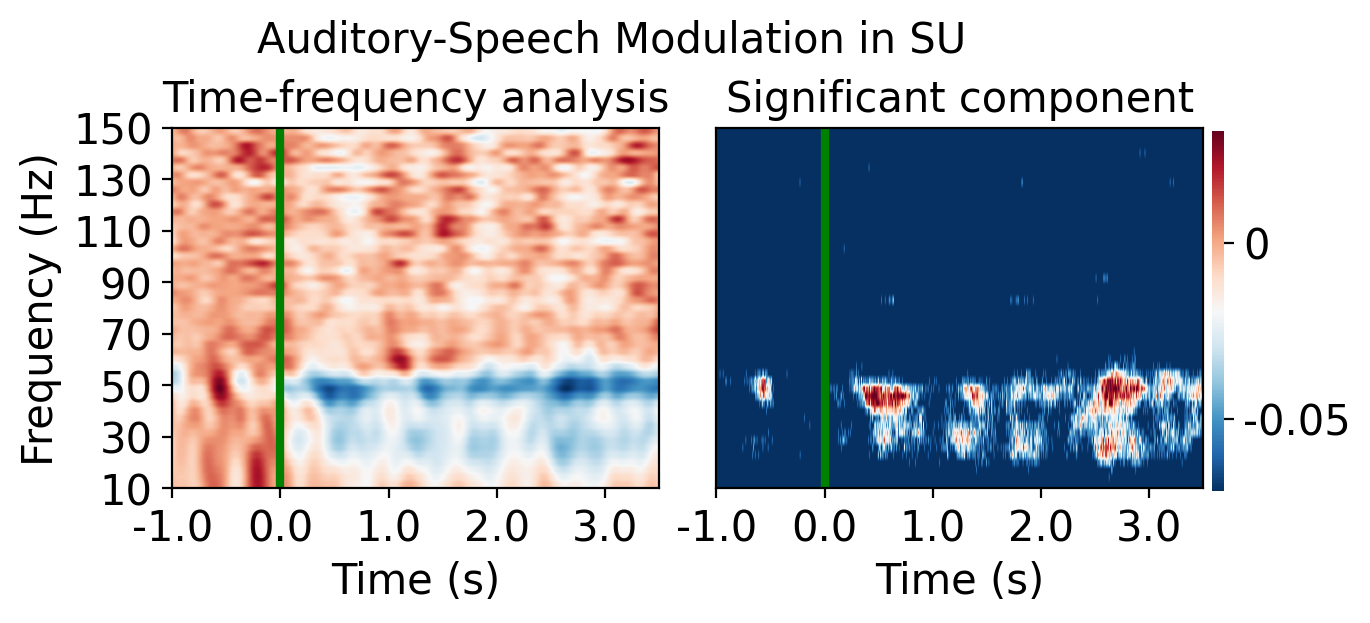

In [23]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(6, 3), dpi=200)
fig.patch.set_alpha(0)
axs[0].patch.set_alpha(0)
axs[0].imshow(power_rescale[:, 500:], extent=extent, aspect="auto", 
        origin="lower", cmap='RdBu_r')

axs[0].set_xticks(np.linspace(0, 4, 5))
axs[0].set_xticklabels(np.linspace(-1, 3, 5), fontsize=15)
axs[0].set_yticks(np.linspace(10, 150, 8))
axs[0].set_yticklabels(np.linspace(10, 150, 8, dtype=int), fontsize=15)
axs[0].set_xlabel('Time (s)', fontsize=15)
axs[0].set_ylabel('Frequency (Hz)', fontsize=15)
axs[0].set_title("Time-frequency analysis", fontsize=15)
axs[0].axvline(1, color='g', linewidth=3)
axs[0].set_xlim(0, 4.5)


axs[1].patch.set_alpha(0)

axs[1].imshow(power_rescale_sig[:, 500:], extent=extent, aspect="auto", 
        origin="lower", cmap='RdBu_r')
axs[1].set_xticks(np.linspace(0, 4, 5))
axs[1].set_xticklabels(np.linspace(-1, 3, 5), fontsize=15)
axs[1].set_yticks([])
axs[1].set_yticklabels([])
axs[1].set_xlabel('Time (s)', fontsize=15)
#axs[1].set_ylabel('Log frequency (Hz)', fontsize=15)
axs[1].set_title("Significant component", fontsize=15)
axs[1].axvline(1, color='g', linewidth=3)
#fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1, 0.2, 0.01, 0.6])
cb = fig.colorbar(im1, cax=cbar_ax)
cbar_ax.tick_params(labelsize=15)
cb.outline.set_linewidth(0)
cb.set_ticks((-0, -0.05))
cb.set_ticklabels([0, -0.05])
axs[1].set_xlim(0, 4.5)

plt.suptitle('Auditory-Speech Modulation in SU', fontsize=15)
plt.plot();


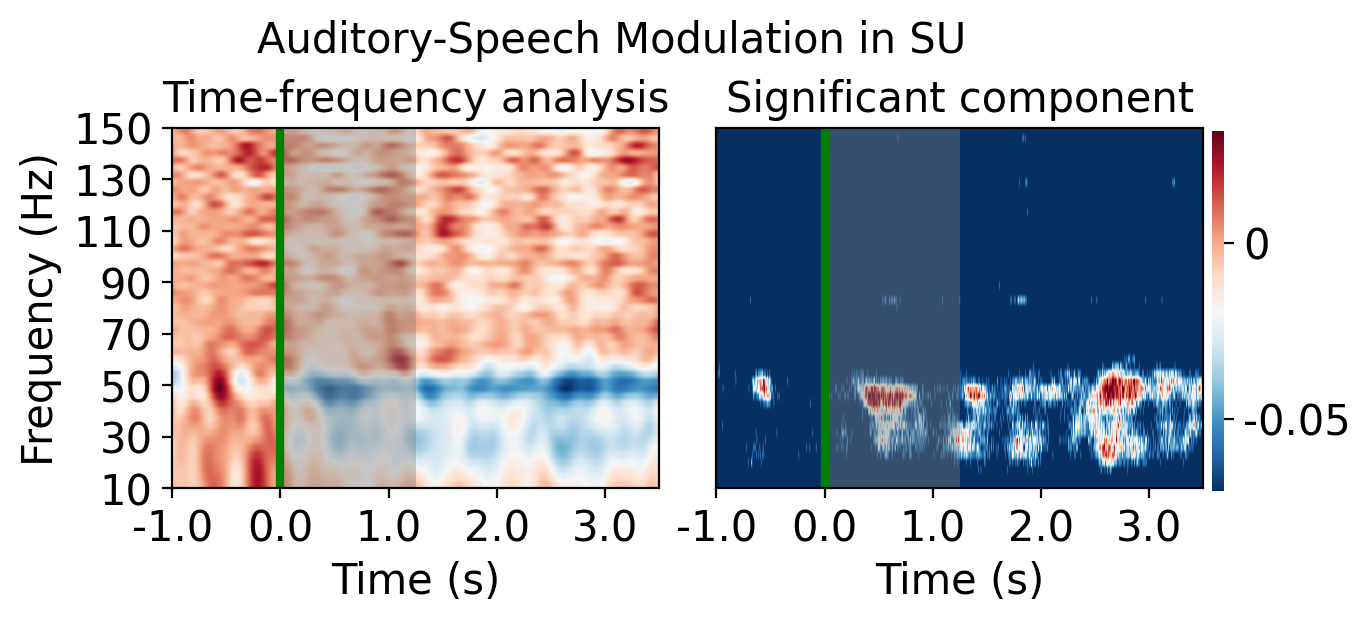

In [32]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(6, 3), dpi=200)
fig.patch.set_alpha(0)
axs[0].patch.set_alpha(0)
axs[0].imshow(power_rescale[:, 500:], extent=extent, aspect="auto", 
        origin="lower", cmap='RdBu_r')

axs[0].set_xticks(np.linspace(0, 4, 5))
axs[0].set_xticklabels(np.linspace(-1, 3, 5), fontsize=15)
axs[0].set_yticks(np.linspace(10, 150, 8))
axs[0].set_yticklabels(np.linspace(10, 150, 8, dtype=int), fontsize=15)
axs[0].set_xlabel('Time (s)', fontsize=15)
axs[0].set_ylabel('Frequency (Hz)', fontsize=15)
axs[0].set_title("Time-frequency analysis", fontsize=15)
axs[0].axvline(1, color='g', linewidth=3)
axs[0].set_xlim(0, 4.5)

rect1 = patches.Rectangle((1, 0), 1.25, 150, edgecolor='none', facecolor='grey', alpha=0.4)
axs[0].add_patch(rect1)


axs[1].patch.set_alpha(0)

axs[1].imshow(power_rescale_sig[:, 500:], extent=extent, aspect="auto", 
        origin="lower", cmap='RdBu_r')
axs[1].set_xticks(np.linspace(0, 4, 5))
axs[1].set_xticklabels(np.linspace(-1, 3, 5), fontsize=15)
axs[1].set_yticks([])
axs[1].set_yticklabels([])
axs[1].set_xlabel('Time (s)', fontsize=15)
#axs[1].set_ylabel('Log frequency (Hz)', fontsize=15)
axs[1].set_title("Significant component", fontsize=15)
axs[1].axvline(1, color='g', linewidth=3)
#fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1, 0.2, 0.01, 0.6])
cb = fig.colorbar(im1, cax=cbar_ax)
cbar_ax.tick_params(labelsize=15)
cb.outline.set_linewidth(0)
cb.set_ticks((-0, -0.05))
cb.set_ticklabels([0, -0.05])
axs[1].set_xlim(0, 4.5)

rect2 = patches.Rectangle((1, 0), 1.25, 150, edgecolor='none', facecolor='grey', alpha=0.4)
axs[1].add_patch(rect2)

plt.suptitle('Auditory-Speech Modulation in SU', fontsize=15)
plt.plot();
